# Spawn Grunt
This is an example with the control data where noise is stronger. If the Demo01 method also works, then it should be enough to capture the cod spawn grunt sound.

In [1]:
# built-in libs and packages 
# import wave
import os
from os import listdir
from os.path import isfile, join

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd 
import math
import librosa
import librosa.display
import seaborn as sns

In [2]:
ls /home/deep/deep/data/codsounds/spawnseis_pilot

20180305_180000.TextGrid*             20180306_031955.TextGrid*
20180305_180000_ch1.wav*              20180306_031955.wav*
20180305_180000_ch1filt.wav           20180306_031955_ch1.wav*
20180305_180000_ch1filtres.wav        20180306_031955_ch2.wav*
20180305_180000_gruntint.csv          20180306_062633.TextGrid*
20180305_180000_onlygrunts.TextGrid*  20180306_062633.wav*
20180306_001316.TextGrid*             20180306_062633_ch1.wav*
20180306_001316.wav*                  20180306_062633_ch2.wav*
20180306_001316_ch1.wav*              Results_Detect_by_Spectrograms/
20180306_001316_ch2.wav*


In [3]:
# paths and files = ""
filepath = "/home/deep/deep/data/codsounds/spawnseis_pilot"

allfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
# [print(ifile) for ifile in allfiles]

filename = "20180306_062633_ch1.wav"  # 20180305_180000_ch1
# annotatecsv = "20180306_062633.TextGrid"
annotatecsv = '20180305_180000_gruntint.csv'

file2read = os.path.join(filepath, filename)
label2read = os.path.join(filepath, annotatecsv)
# check the exist of file and maybe also the quality
if not file2read:
    print("File doesn't exist")
if not label2read:
    print("Annotation file not found")


sample_rate, samples = wavfile.read(file2read)
samples = samples.astype(float)
print("Sample rate {} | Audio size {}".format(sample_rate, samples.shape))

times_sounds = pd.read_csv(label2read, header=0)
# labels = [[e]]
print('\n', '*'*50, '\n', times_sounds.head())
times_sounds.drop('text', axis=1, inplace=True)
print('\n', '*'*50, '\n', times_sounds.head())

Sample rate 48000 | Audio size (269232128,)

 ************************************************** 
          tmin text        tmax
0   35.370033    g   35.495777
1   41.793163    g   41.920901
2  180.043965    g  180.186718
3  198.812336    g  198.956481
4  442.700322    g  442.841759

 ************************************************** 
          tmin        tmax
0   35.370033   35.495777
1   41.793163   41.920901
2  180.043965  180.186718
3  198.812336  198.956481
4  442.700322  442.841759


In [4]:
# samples_8k = librosa.resample(samples, sample_rate, 8000)
# sample_rate_8k = 8000

In [6]:

import IPython.display as ipd   
# index_grunt = np.arange(1900000,2200000, 1) # label 1
# index_grunt = np.arange(1960000,2260000, 1) # label 2
# index_grunt = np.arange(8600000,8900000, 1) # label 3 - one skeptic grunt sound afterwards
# index_grunt = np.arange(9504000,9804000, 1) # label 4 
index_grunt = np.arange(21116000,21516000, 1) # label 5 

# index_grunt = np.arange(1900000,2151600, 1) # first 5 grunts 

# index_noise = np.arange(2020000,2100000, 1)
ipd.Audio(samples[index_grunt], rate = sample_rate) # load a local WAV file

## 2. Preprocessing (deoising)

151407.48399984004
(400000,) (400000,)


/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


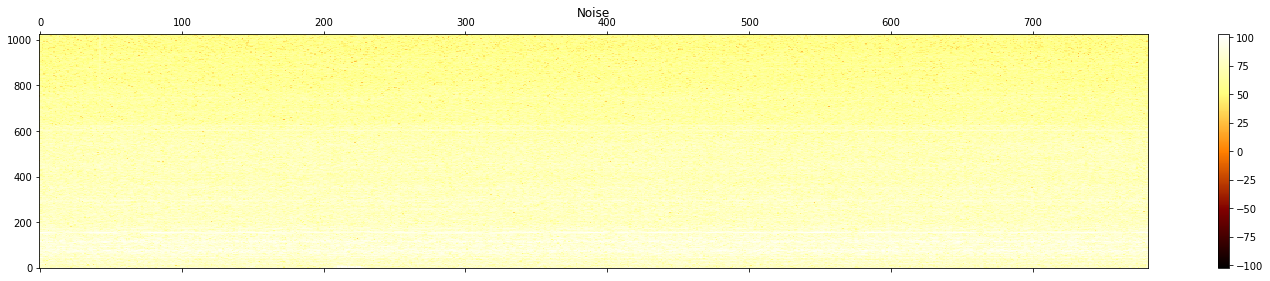

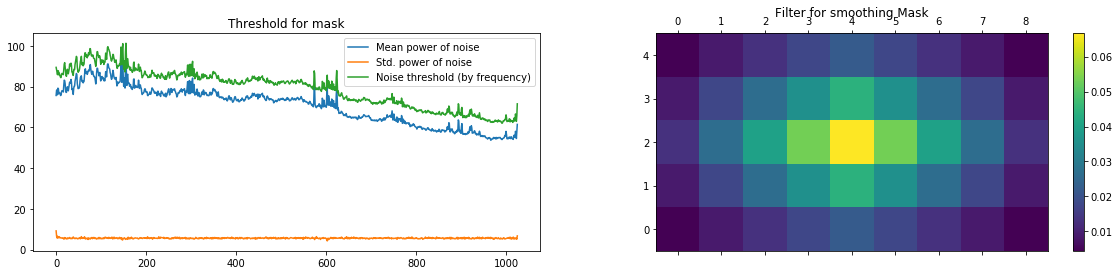

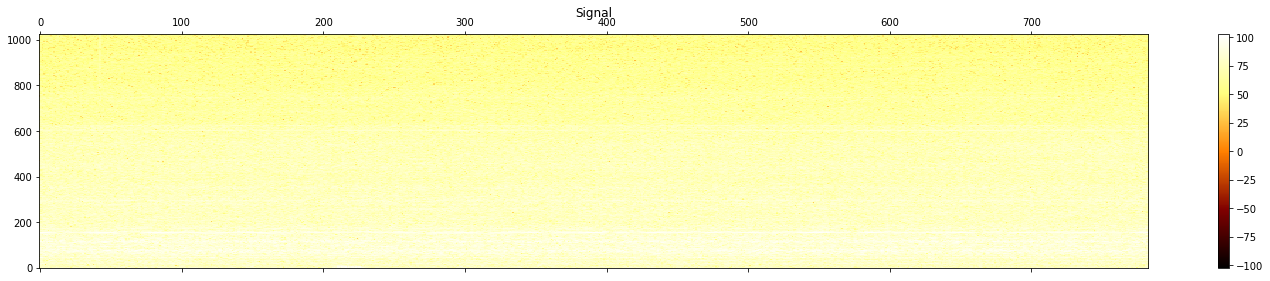

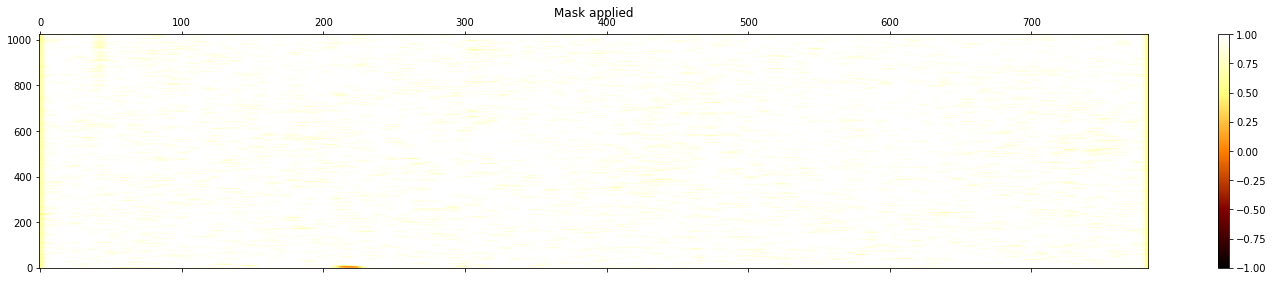

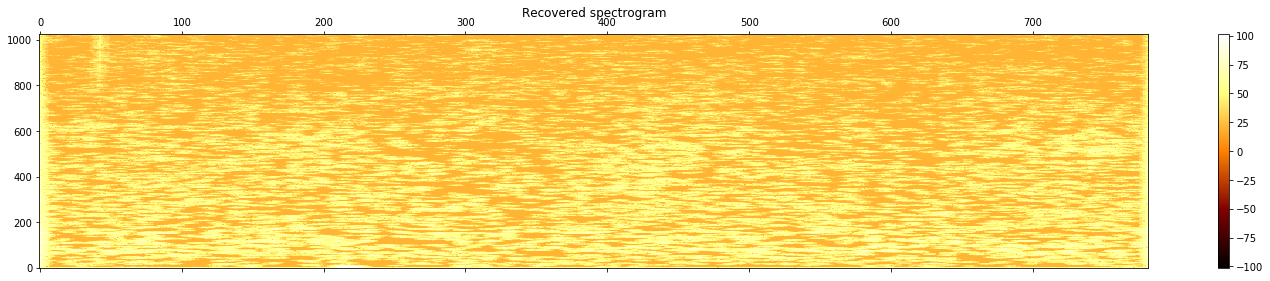

In [8]:
%matplotlib inline
# Calculate the FFT of the samples
from scipy.fftpack import fft, ifft
fft_out = fft(samples[index_grunt])


# plt.subplots(1,1, figsize=(10, 8))
# plt.plot(samples[1970000:2100000], np.abs(fft_out), '-*')
# plt.show()


# from librosa import display
# plt.figure()
# librosa.display.waveplot(y=samples[1970000:2100000], sr = sample_rate)


# Get the mean value and calculate a threshold
mean_value = np.mean(abs(fft_out))
print(mean_value)
threshold  = 0.5 * mean_value; #  Fine-tune this, the larger value the stronger filter

# Remove everything that's below the threshold (we assume that it corresponds to noise)
fft_out[abs(fft_out) < threshold] = 0


threshold  = 1.9 * mean_value; #  Fine-tune this, the larger value the stronger filter
fft_out[abs(fft_out) > threshold] = 0

# Get the filtered samples
filtered_samples = ifft(fft_out)
print(filtered_samples.shape, samples[index_grunt].shape)


##### use noisereduce to filter
sample_clipped = samples[index_grunt]
sample_noise = samples[index_grunt[:]]

# sample_clipped = sample_clipped[s if i%10==0 for i, s in enumerate(sample_clipped)]
# sample_noise = sample_noise[s if i%10==0 for i, s in enumerate(sample_noise)]

import noisereduce as nr
reduced_noise = nr.reduce_noise(audio_clip=sample_clipped, 
                                noise_clip=sample_noise,
                                verbose=True)

# reduced_noise = nr.reduce_noise(audio_clip=filtered_samples.astype(float), 
#                                 noise_clip=filtered_samples[50000:2100000].astype(float),
#                                 verbose=True)


In [10]:
# Manual denoised results
import IPython.display as ipd
print('Denoised by hand-tuned parameter of fft')
ipd.Audio(filtered_samples, rate = sample_rate) # load a local WAV file

Denoised by hand-tuned parameter of fft


In [12]:


# Denoised results by noisereduce
print('Denoised by noisereduce of ifft')
ipd.Audio(reduced_noise, rate = sample_rate) # load a local WAV file

Denoised by noisereduce of ifft


## 3. Detect the grunts with signal processing method

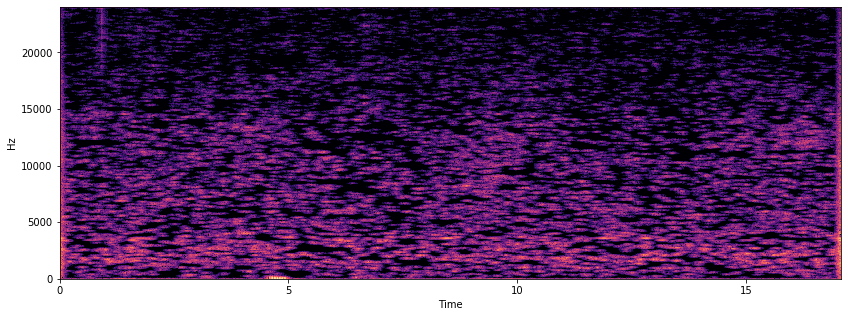

In [16]:
%matplotlib inline
# # Original samples
# X = librosa.stft(samples[index_grunt].astype(float))
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')

# # Manually filtered samples
# X = librosa.stft(filtered_samples.astype(float))
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')

# Denoised samples by noisereduce
X = librosa.stft(reduced_noise.astype(float), n_fft = 2048, win_length=1000)
Xdb = librosa.amplitude_to_db(abs(X))
fig = plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')
data_axes = librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') # hz log
# librosa.feature.melspectrogram(y = np.transpose(Xdb), sr=sample_rate_flt,x_axis='time', y_axis='hz')

(1025, 1601)


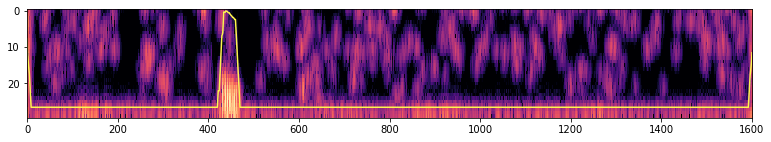

In [15]:
%matplotlib inline
# method 1
# spectrogram= librosa.feature.melspectrogram(
#     y=reduced_noise.astype(float), sr=sample_rate, window='hann',  
#     center=True, pad_mode='reflect', power=2.0)

# method 2
spectrogram = librosa.core.reassigned_spectrogram(
    reduced_noise.astype(float), sr=sample_rate, 
    S=None, n_fft=2048, hop_length=None, win_length=None, 
    window='hann', center=True, reassign_frequencies=True, 
    reassign_times=True, ref_power=1e-06, fill_nan=False, 
    clip=True, pad_mode='reflect')

print(Xdb.shape)
plt.figure(figsize=(13, 2))
plt.imshow(np.flipud(Xdb[0:30, ]), cmap = 'magma',aspect='auto', interpolation='nearest')


from skimage.morphology import disk
from skimage.filters import rank




# prof1 = np.array([np.math.exp(e) for e in prof1])
prof1 = Xdb[1:15,:].mean(0)


val_max = max(prof1)
prof1[prof1<65]=0

prof1_sm = np.empty(prof1.shape)
for i in range(0, len(prof1)):
    prof1_sm[i] = np.mean(prof1[max(0, i-5):min(i+5, len(prof1))])

plt.plot((prof1_sm.max() - prof1_sm)/3, color=[1,0.96,0.3])


In [ ]:
reduced_noise.shape